## Домашняя работа по теме "GAN"

Реулизуем сеть, которая будет генерировать изображения фасадов зданий, используя базу данных фасадов CMP

Архитектура вашей сети будет содержать:

* Генератор с архитектурой на базе U-Net .
* Дискриминатор, представленный свёрточным классификатором PatchGAN

In [1]:
# Импорт TensorFlow и других библиотек
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

Загрузим набор данных

In [2]:
dataset_name = "facades"

_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

30168306/30168306 [==============================] - 68s 2us/step


In [3]:
list(PATH.parent.iterdir())

[WindowsPath('C:/Users/Полина/.keras/datasets/cifar-10-batches-py'),
 WindowsPath('C:/Users/Полина/.keras/datasets/cifar-10-batches-py.tar.gz'),
 WindowsPath('C:/Users/Полина/.keras/datasets/facades'),
 WindowsPath('C:/Users/Полина/.keras/datasets/facades.tar.gz'),
 WindowsPath('C:/Users/Полина/.keras/datasets/fashion-mnist'),
 WindowsPath('C:/Users/Полина/.keras/datasets/imdb.npz')]

In [6]:
sample_image = tf.io.read_file(str(PATH / 'train/10.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


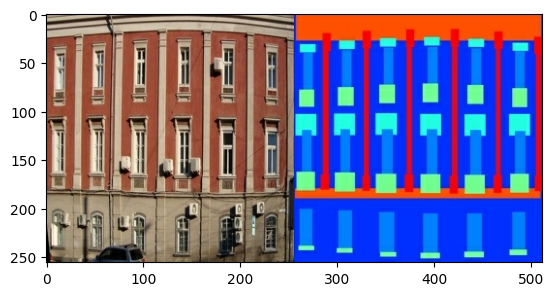

In [7]:
plt.figure()
plt.imshow(sample_image)

Каждое исходное изображение имеет размер 256 x 512 и содержит два изображения размером 256 x 256. Нужно отделить реальные изображения фасадов зданий от изображений архитектурных надписей — все они будут иметь размер 256 x 256 .

Определим функцию, которая загружает файлы изображений и выводит два тензора изображений:

In [8]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

Построим образец входного (изображение архитектурной метки) и реального (фото фасада здания) изображения

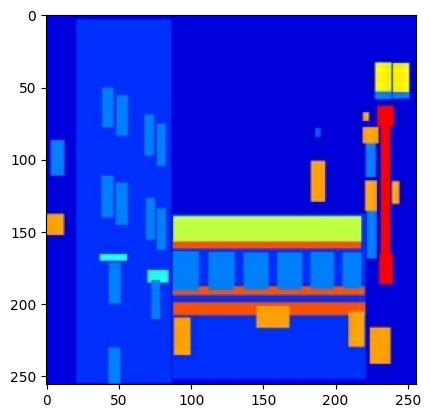

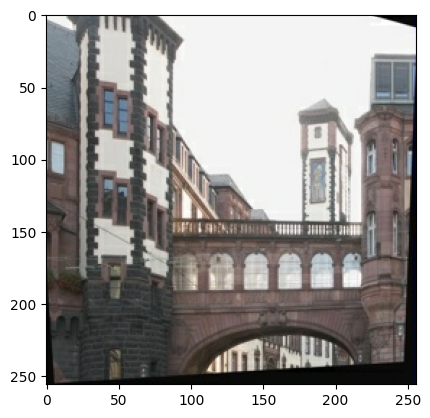

In [24]:
inp, re = load(str(PATH / 'train/47.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

Как описано в статье pix2pix (https://arxiv.org/pdf/1611.07004.pdf) , нам нужно применить случайное дрожание и зеркальное отображение для предварительной обработки обучающего набора.

Определим несколько функций, которые:

* Изменяют размер каждого изображения 256 x 256 на большую высоту и ширину — 286 x 286 .
* Произвольно обрезают его обратно до 256 x 256 .
* Произвольно отражают изображение по горизонтали, т.е. слева направо (случайное зеркальное отображение).
* Нормализуют изображения в диапазоне [-1, 1] .

In [25]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [26]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [27]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [28]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [29]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

Проверим часть предварительно обработанного вывода

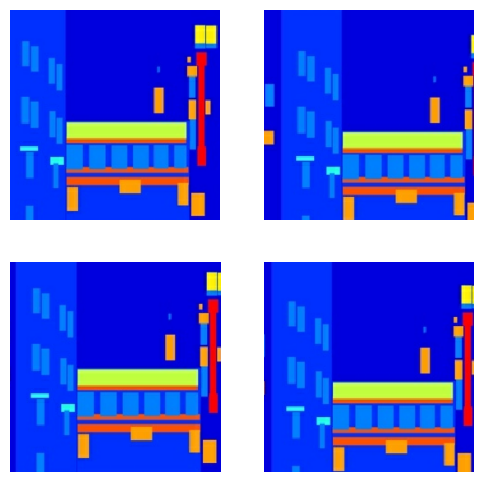

In [30]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

Теперь определим пару вспомогательных функций, которые загружают и предварительно обрабатывают обучающий и тестовый наборы

In [31]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [32]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

### Создадим конвейер ввода с помощью tf.data

In [33]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [34]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Построим генератор

Генератор вашего pix2pix cGAN представляет собой модифицированный U-Net . U-Net состоит из кодера (понижающего дискретизатора) и декодера (апсемплера). 
* Каждый блок в кодировщике: свертка -> нормализация партии -> дырявый ReLU
* Каждый блок в декодере: Транспонированная свертка -> Нормализация партии -> Выпадение (применяется к первым 3 блокам) -> ReLU
* Между энкодером и декодером есть пропускные соединения (как в U-Net).

Определим понижающий дискретизатор (кодер):

In [35]:
OUTPUT_CHANNELS = 3

In [36]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [37]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


Определим повышающий дискретизатор (декодер):

In [38]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [39]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


Определим генератор с понижающим дискретизатором и повышающим дискретизатором:

In [40]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Визуализируем архитектуру модели генератора:

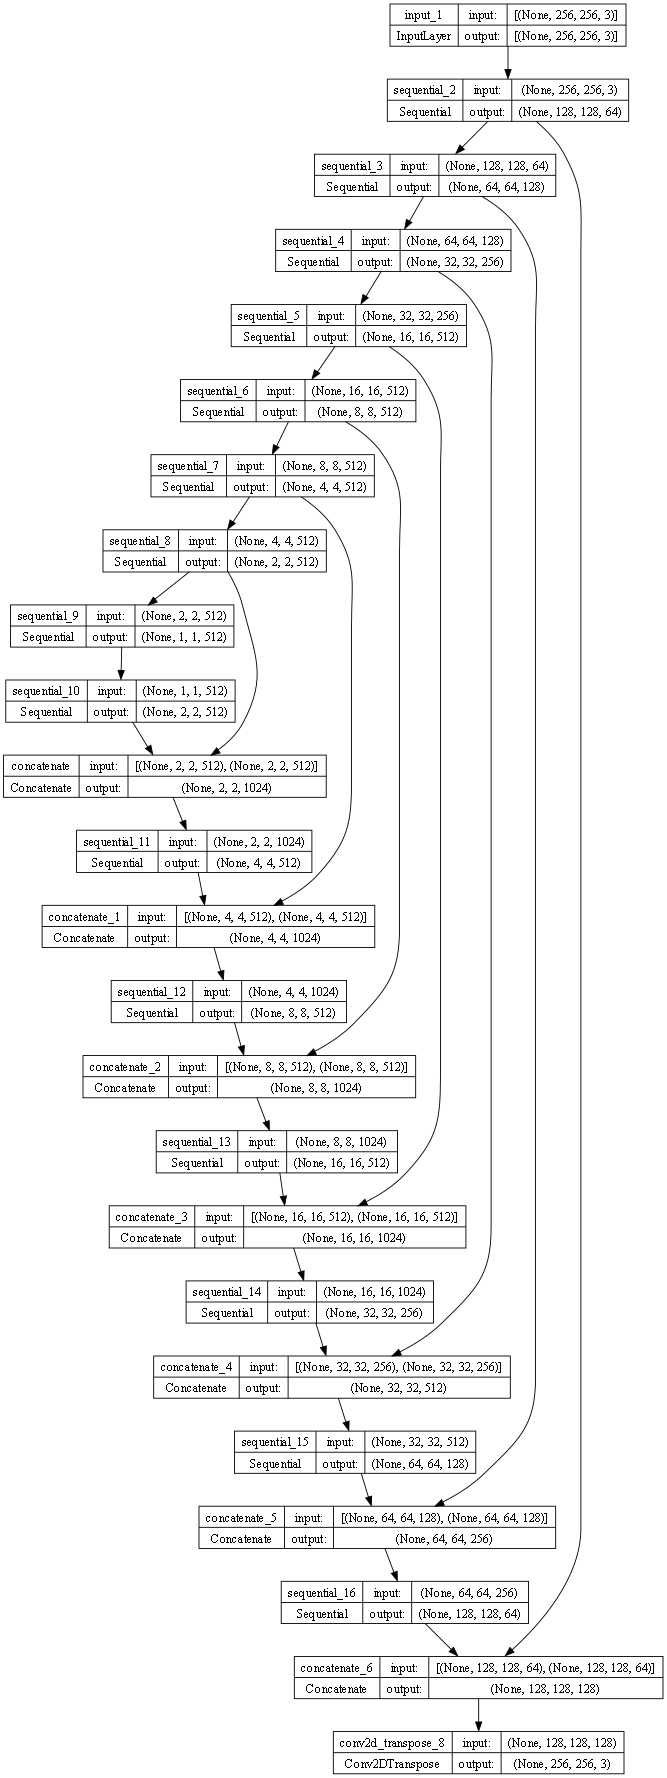

In [41]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Протестируем генератор:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


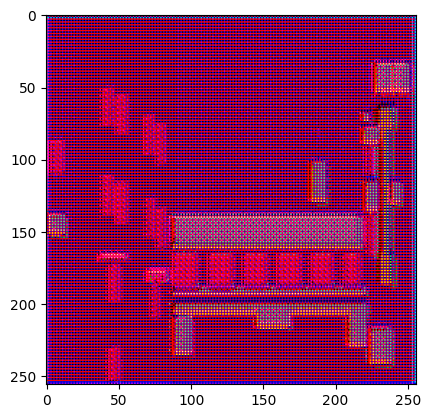

In [42]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

Определим потери генератора

GAN изучают потери, которые адаптируются к данным, в то время как cGAN изучают структурированные потери, которые наказывают возможную структуру, которая отличается от вывода сети и целевого изображения, как описано в статье pix2pix .

* Потеря генератора представляет собой сигмовидную кросс-энтропийную потерю сгенерированных изображений и массива из них .
* В документе pix2pix также упоминается потеря L1, которая представляет собой MAE (средняя абсолютная ошибка) между сгенерированным изображением и целевым изображением.
* Это позволяет сгенерированному изображению стать структурно похожим на целевое изображение.
* Формула для расчета общих потерь генератора: gan_loss + LAMBDA * l1_loss , где LAMBDA = 100 . Это значение было определено авторами статьи.

In [43]:
LAMBDA = 100

In [44]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [45]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

### Создадим дискриминатор

Дискриминатор в pix2pix cGAN представляет собой сверточный классификатор PatchGAN — он пытается классифицировать, является ли каждый фрагмент изображения реальным или нет, как описано в статье pix2pix

* Каждый блок в дискриминаторе: свертка -> нормализация партии -> дырявый ReLU.
* Форма вывода после последнего слоя (batch_size, 30, 30, 1) .
* Каждый фрагмент выходного изображения 30 x 30 классифицирует часть входного изображения размером 70 x 70 .
* Дискриминатор получает 2 входа:
    * Входное изображение и целевое изображение, которое следует классифицировать как реальное.
    * Входное изображение и сгенерированное изображение (выход генератора), которое он должен классифицировать как подделку.
    * Используем tf.concat([inp, tar], axis=-1) , чтобы соединить эти 2 входа вместе.

Определим дискриминатор:

In [46]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

Визуализируем архитектуру модели дискриминатора:

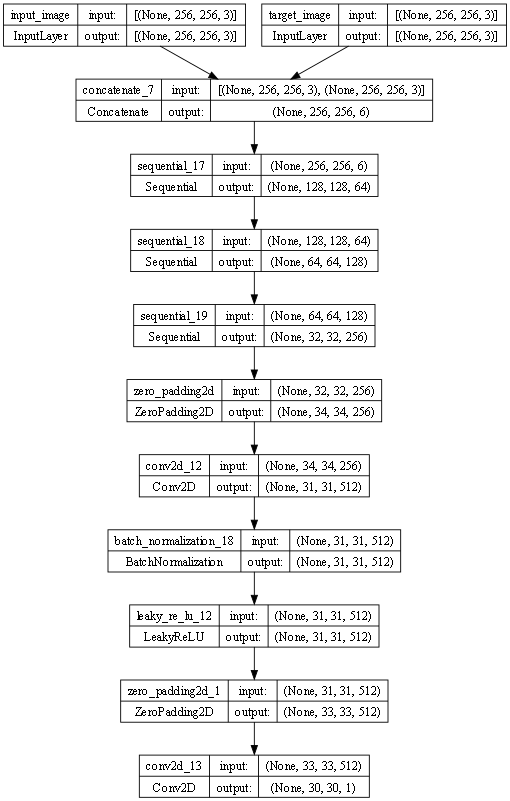

In [47]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Протестируем дискриминатор:

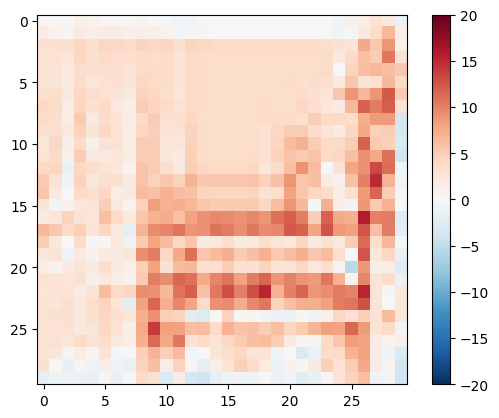

In [48]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

Определим потери дискриминатора

* Функция discriminator_loss принимает 2 входа: реальные изображения и сгенерированные изображения
* real_loss — это сигмовидная кросс-энтропийная потеря реальных изображений и массива единиц (поскольку это настоящие изображения)
* generated_loss — это сигмовидная кросс-энтропийная потеря сгенерированных изображений и массив нулей (поскольку это поддельные изображения)
* total_loss — это сумма real_loss и generated_los

In [49]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### Определим оптимизаторы и средство сохранения контрольных точек

In [50]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [51]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Создание изображений

Напишем функцию для построения изображений во время обучения.

* Передадим изображения из тестового набора в генератор.
* Затем генератор преобразует входное изображение в выходное.
* Последний шаг — построение прогнозов

In [52]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

Протестируем функцию:

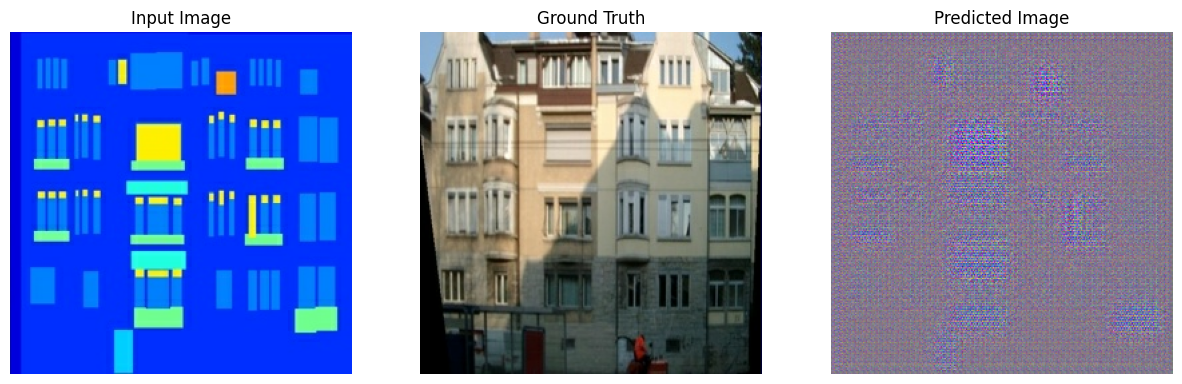

In [55]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

### Обучение

* Для каждого примера ввод генерирует вывод.
* Дискриминатор получает input_image и сгенерированное изображение в качестве первого входа. Второй вход — это input_image и target_image .
* Затем вычисляются потери генератора и дискриминатора.
* Затем вычисляются градиенты потерь как для генератора, так и для переменных (входных данных) дискриминатора и применяются к оптимизатору.
* Наконец, регистрация потерь в TensorBoard.

In [56]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [57]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [58]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

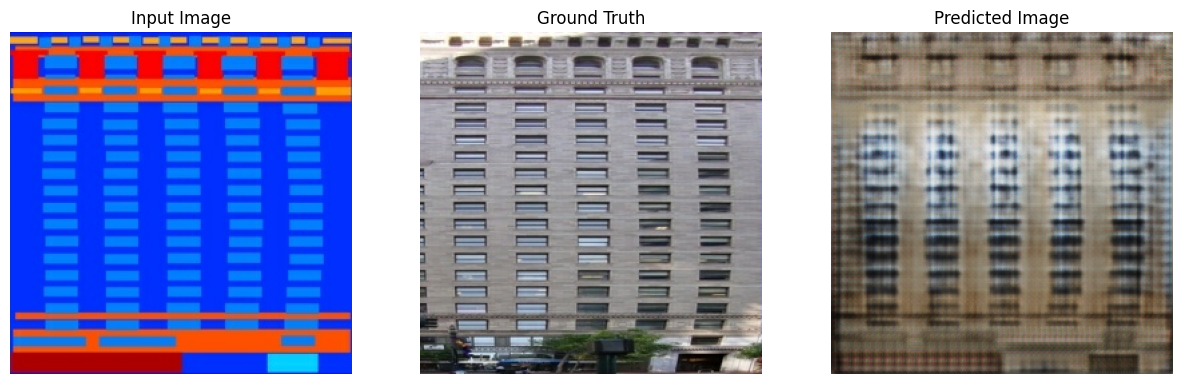

Step: 0k
..........

In [62]:
fit(train_dataset, test_dataset, steps=100)

Сеть обучалась не на 100 шагах (как указано выше), а на 1500 (пришлось прервать процесс обучения, так как занимал большое количество времени). Но из этого можно сделать вывод, что чем больше шагов, тем точнее генерируется изображение.

### Создадим несколько изображений, используя тестовый набор

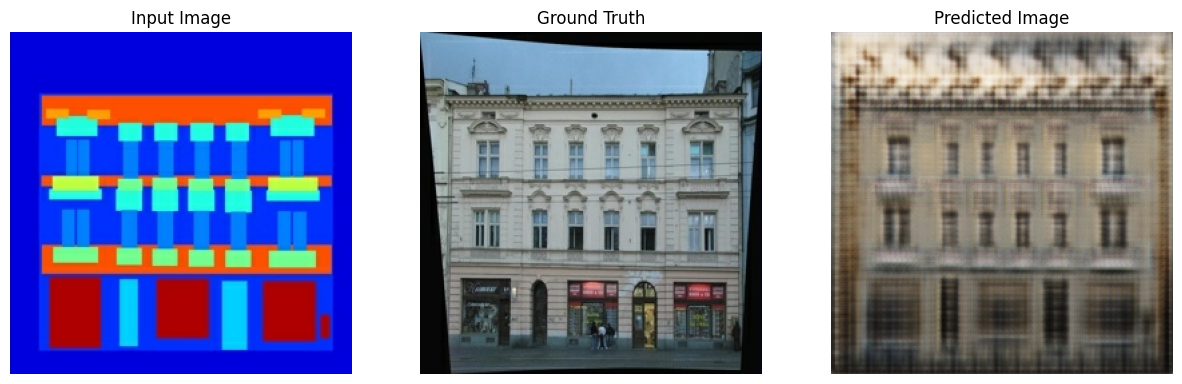

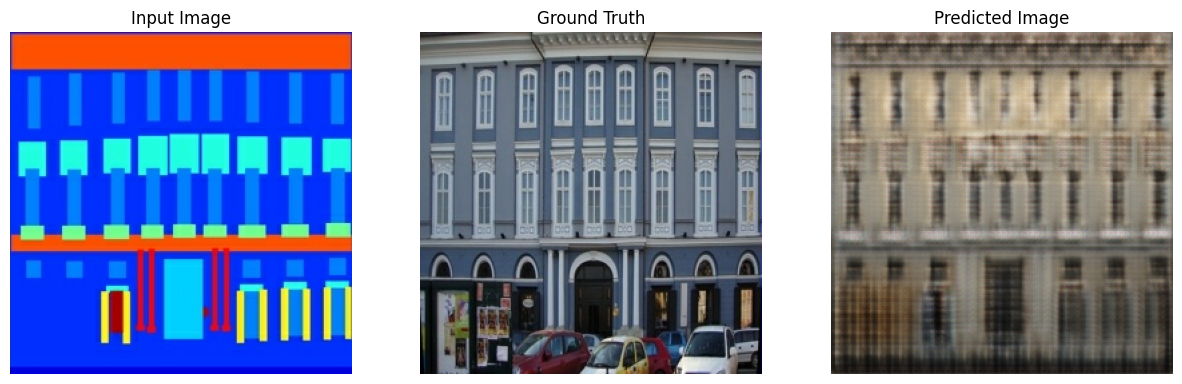

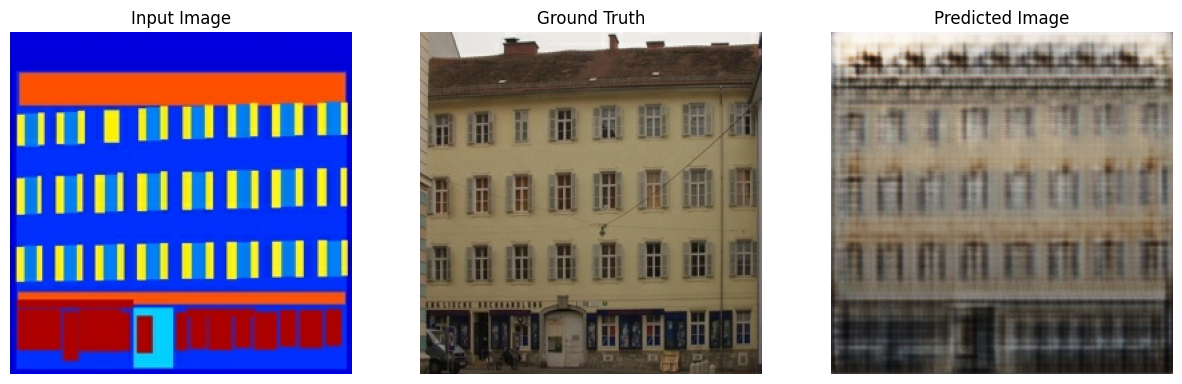

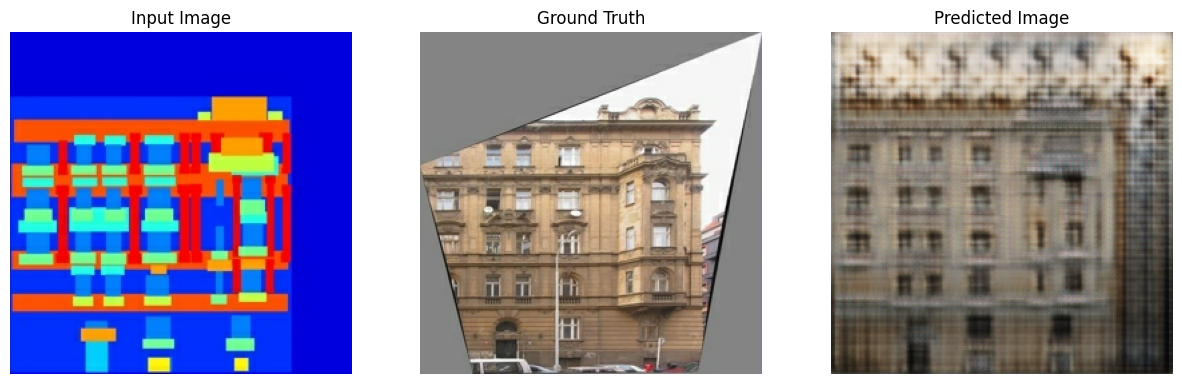

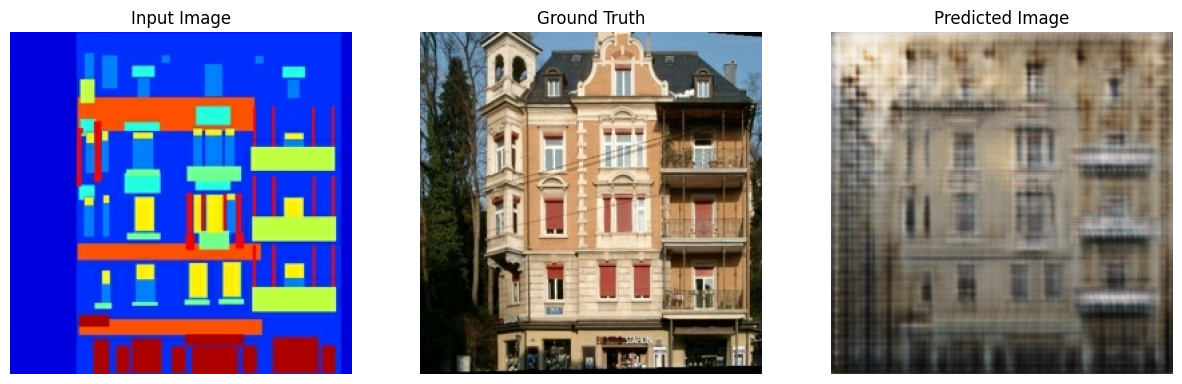

In [63]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)